In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import re
import math
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split

**Load and Preprocess the Dataset**

In [2]:
file_path = "/kaggle/input/shakespeare-huggingface/input.txt"
with open(file_path, "r", encoding="utf-8") as f:
    text = f.read()

print(text[:500])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [3]:
text = text.lower()
print("After lowering: ",text[:500])
text = re.sub(r'[^a-z\s]', '', text)
print("After removin: ",text[:500])
tokens = text.split()

After lowering:  first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you are all resolved rather to die than to famish?

all:
resolved. resolved.

first citizen:
first, you know caius marcius is chief enemy to the people.

all:
we know't, we know't.

first citizen:
let us kill him, and we'll have corn at our own price.
is't a verdict?

all:
no more talking on't; let it be done: away, away!

second citizen:
one word, good citizens.

first citizen:
we are accounted poor
After removin:  first citizen
before we proceed any further hear me speak

all
speak speak

first citizen
you are all resolved rather to die than to famish

all
resolved resolved

first citizen
first you know caius marcius is chief enemy to the people

all
we knowt we knowt

first citizen
let us kill him and well have corn at our own price
ist a verdict

all
no more talking ont let it be done away away

second citizen
one word good citizens

first citizen
we are accounted poor 

In [4]:
vocab = sorted(set(tokens))
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for i, w in enumerate(vocab)}
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)

Vocabulary size: 12847


In [5]:
sequence_length = 10
inputs = []
labels = []
for i in range(len(tokens) - sequence_length):
    seq = tokens[i:i+sequence_length]
    label = tokens[i+sequence_length]
    inputs.append([word2idx[w] for w in seq])
    labels.append(word2idx[label])
inputs = np.array(inputs)
labels = np.array(labels)
print("Total sequences:", inputs.shape[0])

Total sequences: 202609


In [6]:
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.2, random_state=42)

**Custom Vanilla RNN Cell**

In [7]:
class VanillaRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(VanillaRNNCell, self).__init__(**kwargs)  
        self.units = units  

    @property
    def state_size(self):
        return self.units
    
    def build(self, input_shape):
        self.Wxh = self.add_weight(shape=(input_shape[-1], self.units),
                                   initializer='glorot_uniform',
                                   name='Wxh')
        self.Whh = self.add_weight(shape=(self.units, self.units),
                                   initializer='orthogonal',
                                   name='Whh')
        self.bh = self.add_weight(shape=(self.units,),
                                  initializer='zeros',
                                  name='bh')
        super().build(input_shape)  # `super().build()` is called correctly
    
    def call(self, inputs, states):
        prev_h = states[0]
        h = tf.nn.tanh(tf.matmul(inputs, self.Wxh) + tf.matmul(prev_h, self.Whh) + self.bh)
        return h, [h]


In [8]:
def create_rnn_model(vocab_size, embedding_dim, rnn_units, sequence_length, 
                     use_pretrained=False, embedding_matrix=None):
    model = tf.keras.Sequential()
    if use_pretrained and embedding_matrix is not None:
        model.add(tf.keras.layers.Embedding(
            input_dim=vocab_size, 
            output_dim=embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
            trainable=False))
    else:
        model.add(tf.keras.layers.Embedding(
            input_dim=vocab_size, 
            output_dim=embedding_dim))
        
    cell = VanillaRNNCell(rnn_units)
    model.add(tf.keras.layers.RNN(cell))
    model.add(tf.keras.layers.Dense(vocab_size, activation='softmax'))
    return model

In [9]:
embedding_dim = 50
rnn_units = 128

embedding_matrix = np.random.rand(vocab_size, embedding_dim)
model_random = create_rnn_model(vocab_size, embedding_dim, rnn_units, sequence_length, use_pretrained=False)
model_pretrained = create_rnn_model(vocab_size, embedding_dim, rnn_units, sequence_length, 
                                    use_pretrained=True, embedding_matrix=embedding_matrix)

In [10]:
model_random.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_pretrained.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
print("\nTraining model with random (learned) embeddings...")
history_random = model_random.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.1, verbose=2)

print("\nTraining model with pretrained embeddings...")
history_pretrained = model_pretrained.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.1, verbose=2)


Training model with random (learned) embeddings...
Epoch 1/20
1140/1140 - 72s - 63ms/step - accuracy: 0.0809 - loss: 6.1083 - val_accuracy: 0.0828 - val_loss: 6.3299
Epoch 2/20
1140/1140 - 80s - 70ms/step - accuracy: 0.0925 - loss: 5.7917 - val_accuracy: 0.0851 - val_loss: 6.3213
Epoch 3/20
1140/1140 - 69s - 61ms/step - accuracy: 0.1032 - loss: 5.5212 - val_accuracy: 0.0868 - val_loss: 6.3567
Epoch 4/20
1140/1140 - 81s - 71ms/step - accuracy: 0.1141 - loss: 5.2741 - val_accuracy: 0.0859 - val_loss: 6.4227
Epoch 5/20
1140/1140 - 70s - 62ms/step - accuracy: 0.1254 - loss: 5.0447 - val_accuracy: 0.0843 - val_loss: 6.5073
Epoch 6/20
1140/1140 - 81s - 71ms/step - accuracy: 0.1430 - loss: 4.8258 - val_accuracy: 0.0839 - val_loss: 6.5826
Epoch 7/20
1140/1140 - 69s - 61ms/step - accuracy: 0.1639 - loss: 4.6181 - val_accuracy: 0.0803 - val_loss: 6.6721
Epoch 8/20
1140/1140 - 81s - 71ms/step - accuracy: 0.1879 - loss: 4.4184 - val_accuracy: 0.0795 - val_loss: 6.7673
Epoch 9/20
1140/1140 - 69s -

In [13]:
loss_random, acc_random = model_random.evaluate(X_test, y_test, verbose=0)
loss_pretrained, acc_pretrained = model_pretrained.evaluate(X_test, y_test, verbose=0)

perplexity_random = math.exp(loss_random)
perplexity_pretrained = math.exp(loss_pretrained)

print("\nModel with Random Embeddings - Test Accuracy: {:.4f}, Perplexity: {:.4f}".format(acc_random, perplexity_random))
print("Model with Pretrained Embeddings - Test Accuracy: {:.4f}, Perplexity: {:.4f}".format(acc_pretrained, perplexity_pretrained))


Model with Random Embeddings - Test Accuracy: 0.0629, Perplexity: 2512.3678
Model with Pretrained Embeddings - Test Accuracy: 0.0587, Perplexity: 1687.3281


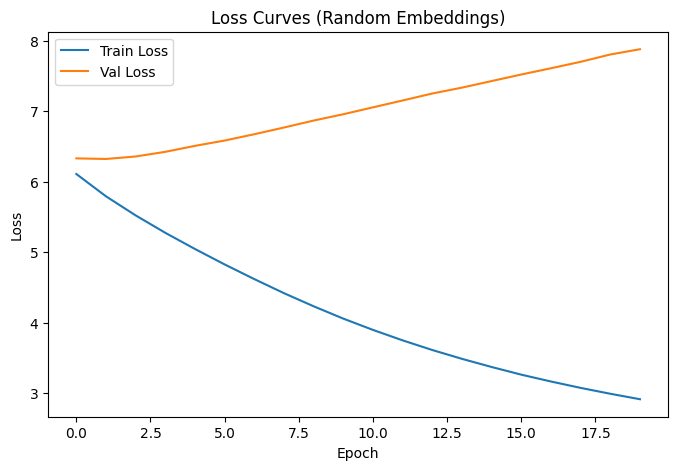

In [14]:
plt.figure(figsize=(8,5))
plt.plot(history_random.history['loss'], label='Train Loss')
plt.plot(history_random.history['val_loss'], label='Val Loss')
plt.title("Loss Curves (Random Embeddings)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Generate Text Predictions**

In [15]:
def generate_text(model, seed_text, num_words, word2idx, idx2word, sequence_length):
    current_sequence = [word2idx[w] for w in seed_text.lower().split() if w in word2idx]
    current_sequence = current_sequence[-sequence_length:]
    generated = seed_text
    for _ in range(num_words):
        padded = tf.keras.preprocessing.sequence.pad_sequences([current_sequence], maxlen=sequence_length, padding='pre')
        pred_probs = model.predict(padded, verbose=0)[0]
        next_idx = np.argmax(pred_probs)
        next_word = idx2word[next_idx]
        generated += " " + next_word
        current_sequence.append(next_idx)
        current_sequence = current_sequence[1:]
    return generated

In [16]:
seed_phrase = "to be or not to"
generated_random = generate_text(model_random, seed_phrase, 10, word2idx, idx2word, sequence_length)
generated_pretrained = generate_text(model_pretrained, seed_phrase, 10, word2idx, idx2word, sequence_length)

In [17]:
print("\nGenerated text with Random Embeddings:")
print(generated_random)
print("\nGenerated text with Pretrained Embeddings:")
print(generated_pretrained)


Generated text with Random Embeddings:
to be or not to draw the dimming to fight and with the seas and

Generated text with Pretrained Embeddings:
to be or not to the ground a tooth and odd the gentleman of the


In [18]:
results_df = pd.DataFrame({
    "Embedding Type": ["Random Embeddings", "Pretrained Embeddings"],
    "Word-Level Accuracy": [acc_random, acc_pretrained],
    "Perplexity": [perplexity_random, perplexity_pretrained]
})

In [19]:
print("\nTable 2: Comparison of Word-Level Accuracy and Perplexity for Different Embeddings")
print(results_df)


Table 2: Comparison of Word-Level Accuracy and Perplexity for Different Embeddings
          Embedding Type  Word-Level Accuracy   Perplexity
0      Random Embeddings             0.062879  2512.367771
1  Pretrained Embeddings             0.058659  1687.328060
